In [21]:
import matplotlib.image as mpimg
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2yiq
from collections import defaultdict 
import cv2
%matplotlib inline

In [22]:
img = io.imread('test.png')
img_s = io.imread('test_s.png')
print(img.dtype, img.shape)
print(img[549, 999])
print(img_s[549, 999])
g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
g_img_s = cv2.cvtColor(img_s, cv2.COLOR_RGB2GRAY)
print(g_img[549, 999])
print(g_img_s[549, 999])

uint8 (550, 1000, 4)
[101  83  69 255]
[101  83  69 255]
87
87


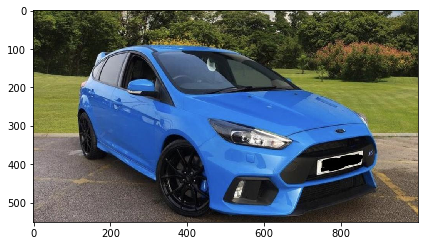

In [23]:
io.imshow(img)

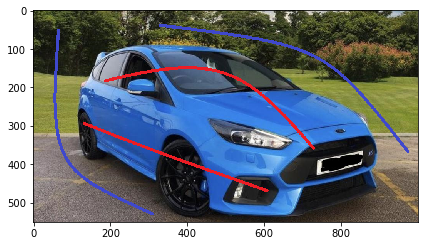

In [24]:
io.imshow(img_s)

In [25]:
scribble = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if g_img[i,j] !=  g_img_s[i,j]:
            scribble.append((i,j))
# print(scribble)

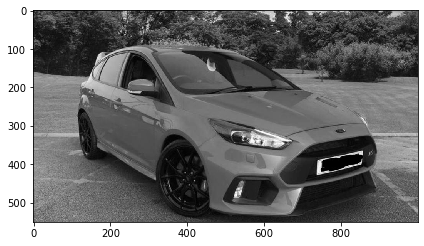

In [26]:
io.imshow(g_img)

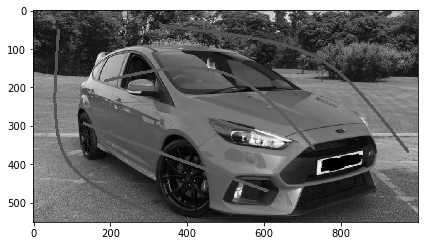

In [27]:
io.imshow(g_img_s)

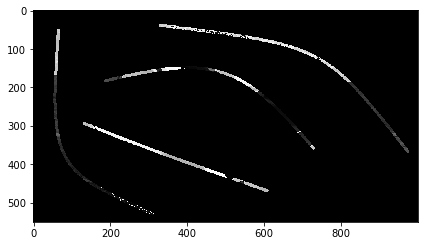

In [28]:
diff = g_img - g_img_s
io.imshow(diff)
io.imsave('diff.png', diff)

In [29]:
scribble_diff = []
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        if diff[i,j] > 0:
            scribble_diff.append((i,j))
# print(scribble_diff)

In [30]:
scribble == scribble_diff # Need to see why 

True

In [31]:
img_s_key = set()
for i, j in scribble:
    img_s_key.add(tuple(img_s[i,j,:3]))
img_s_key # should only have two values
# Need to check that the scribbles are purely a single colour and do not shade at the edges

{(63, 72, 204), (237, 28, 36)}

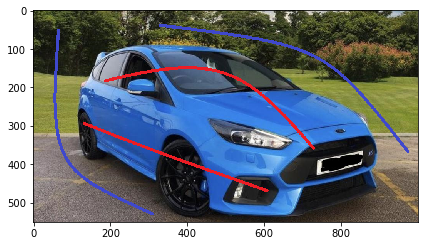

In [32]:
io.imshow(img_s)

In [33]:
if (img[549, 999] == img_s[549, 999]).all():
    print('ok')

ok


In [34]:
def compute_pdfs(imfile, imfile_scrib):
    rgb = mpimg.imread(imfile)[:,:,:3]
    yuv = rgb2yiq(rgb)
    rgb_s = mpimg.imread(imfile_scrib)[:,:,:3]
    yuv_s = rgb2yiq(rgb_s)
    # io.imshow(rgb)
    # io.imshow(rgb_s)
    def find_marked_locations(rgb, rgb_s):
        g = cv2.cvtColor(io.imread(rgb), cv2.COLOR_RGB2GRAY)
        g_s = cv2.cvtColor(io.imread(rgb_s), cv2.COLOR_RGB2GRAY)
        scribble = []
        for i in range(g.shape[0]):
            for j in range(g.shape[1]):
                if g[i,j] !=  g_s[i,j]:
                    scribble.append((i,j))
        return scribble
    
    # find the scribble pixels    
    # scribbles = find_marked_locations(rgb, rgb_s)
    scribbles = find_marked_locations(imfile, imfile_scrib)
    if not scribbles:
        raise Exception

    imageo = np.zeros(yuv.shape)
    
    # separately store background and foreground scribble pixels in the dictionary comps
    comps = defaultdict(lambda:np.array([]).reshape(0,3))
    for (i, j) in scribbles:
         imageo[i,j,:] = rgb_s[i,j,:]
         # scribble color as key of comps
         comps[tuple(imageo[i,j,:])] = np.vstack([comps[tuple(imageo[i,j,:])], yuv[i,j,:]])
         mu, Sigma = {}, {}
    # compute MLE parameters for Gaussians
    for c in comps:
         mu[c] = np.mean(comps[c], axis=0)
         Sigma[c] = np.cov(comps[c].T)
    return (mu, Sigma)

In [35]:
# Check to see what they mean
m, s = compute_pdfs('test.png', 'test_s.png')

In [36]:
m

{(0.24705882370471954,
  0.2823529541492462,
  0.800000011920929): array([ 0.35788471,  0.04351169, -0.04025798]),
 (0.929411768913269,
  0.10980392247438431,
  0.1411764770746231): array([ 0.28854334, -0.11953232,  0.03032429])}

In [37]:
s

{(0.24705882370471954,
  0.2823529541492462,
  0.800000011920929): array([[ 0.02901452,  0.00399796, -0.00256678],
        [ 0.00399796,  0.00088867, -0.00091781],
        [-0.00256678, -0.00091781,  0.00163366]]),
 (0.929411768913269,
  0.10980392247438431,
  0.1411764770746231): array([[ 0.02928617, -0.01127567,  0.00223877],
        [-0.01127567,  0.01268584, -0.0032184 ],
        [ 0.00223877, -0.0032184 ,  0.00098138]])}

--------------------------------------------------
## Constructing Graph for QA from g_img Intensities

In [40]:
for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        pass
print(i, j, pxij)
g_img[0,0]

549 999 87


54

In [41]:
import math
import dimod
from tqdm import tqdm
img = io.imread('test.png')
g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
std = np.std(g_img)
std

46.35743058460294

#### Constructing QUBO Model BQM

In [42]:
r, c = g_img.shape[:2]
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        # Just putting Intensity for now
        bqm.add_variable(i*c + j, pxij)

for i, pxi in tqdm(enumerate(g_img)):
    for j, pxij in enumerate(pxi):
        # print(i , j)
        if i-1 >= 0:
            #Up
            a, b = i*c + j, (i-1)*c + j
            # print('UP:', a, b)
            Ia, Ib = pxij, g_img[i-1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if i+1 < r:
            #Down
            a, b = i*c + j, (i+1)*c + j
            # print('DOWN:', a, b)
            Ia, Ib = pxij, g_img[i+1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if j-1 >= 0:
            #Left
            a, b = i*c + j, i*c + (j-1)
            # print('LEFT:', a, b)
            Ia, Ib = pxij, g_img[i, j-1]
            power = ((Ia -Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))
        if j+1 < c:
            #Right
            a, b = i*c + j, i*c + (j+1)
            # print('RIGHT:', a, b)
            Ia, Ib = pxij, g_img[i, j+1]
            power = ((Ia-Ib)**2)/(2*(std**2))
            bqm.add_interaction(a, b, math.exp(-power))

0it [00:00, ?it/s]C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in ubyte_scalars
1it [00:00,  8.02it/s]C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  app.launch_new_instance()
550it [01:04,  8.57it/s]


#### Constructing Spin/Ising Model BQM

In [43]:
h = {}
J = {}

for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        # Just putting Intensity for now
        h[i*c + j] = pxij

for i, pxi in tqdm(enumerate(g_img)):
    for j, pxij in enumerate(pxi):
        # print(i , j)
        if i-1 >= 0:
            #Up
            a, b = i*c + j, (i-1)*c + j
            # print('UP:', a, b)
            Ia, Ib = pxij, g_img[i-1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)
        if i+1 < r:
            #Down
            a, b = i*c + j, (i+1)*c + j
            # print('DOWN:', a, b)
            Ia, Ib = pxij, g_img[i+1, j]
            power = ((Ia -Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)
        if j-1 >= 0:
            #Left
            a, b = i*c + j, i*c + (j-1)
            # print('LEFT:', a, b)
            Ia, Ib = pxij, g_img[i, j-1]
            power = ((Ia -Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)
        if j+1 < c:
            #Right
            a, b = i*c + j, i*c + (j+1)
            # print('RIGHT:', a, b)
            Ia, Ib = pxij, g_img[i, j+1]
            power = ((Ia-Ib)**2)/(2*(std**2))
            J[(a, b)] = math.exp(-power)

0it [00:00, ?it/s]C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\nipun\envs\qcp\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars
550it [00:43, 12.75it/s]


In [49]:
len(h)

550000

In [50]:
len(J)

2196900